# ETTh1에 대해서 수행

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_forecasting.metrics import SMAPE,MAE,RMSE
from captum.attr import IntegratedGradients,NoiseTunnel

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
a = np.array([[1,2,3,4],[1,2,3,4]])
b = np.array([[0,1,0,1],[1,0,1,0]])
c = a*b
c[0,0]=1
c

array([[1, 2, 0, 4],
       [1, 0, 3, 0]])

In [21]:
a = [[1,2,3],[4,5,6]]
len(a)

2

## 1. 모델 구성하기
* 이전과 다르게 sequence_length를 720 즉 30일을 바라봄

In [2]:
def MSE(pred,target):
    return torch.mean((pred-target)**2,dim = 0) # reduction까지 취해줌

In [3]:
data = pd.read_csv('../../GeneralData/ETTh1.csv')
sequence_length = 720
pred_len = 360

## 2. Sequence중에 빈 시간이 없나 Check

In [4]:
import datetime as dt

In [5]:
data['date'] = pd.to_datetime(data['date'])
for i in range(data.shape[0]-1):
    if data['date'].iloc[i]+dt.timedelta(hours = 1) == data['date'].iloc[i+1]: continue        
    else: print(i)

### &rightarrow; 빈시간 없음

In [6]:
data = data[['OT']]

In [7]:
data

,OT
0,30.531000
1,27.787001
2,27.787001
3,25.044001
4,21.948000
...,...
17415,10.904000
17416,11.044000
17417,10.271000
17418,9.778000


<AxesSubplot: >

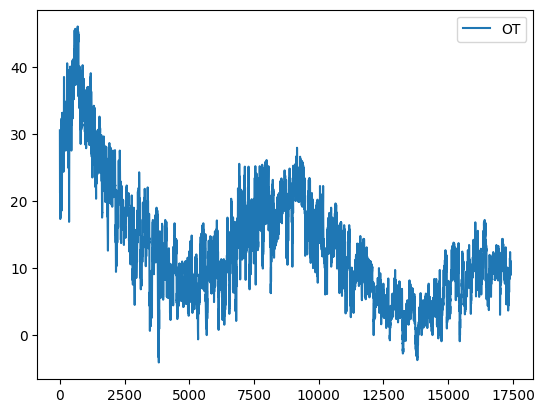

In [8]:
data.plot()

In [9]:
from torch import FloatTensor as FloatTensor

In [10]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(0,len(x)-sequence_length-pred_len+1):
        seq_list.append(x.iloc[i:i+sequence_length].values)
        target_list.append(x.iloc[i+sequence_length:i+sequence_length+pred_len].values)
        
    return FloatTensor(seq_list).view(-1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,pred_len).to(device)

In [11]:
split = 24*7 # 24시간 x 7로써 1주일을 테스트셋으로 만듦

In [12]:
seed = 42

In [13]:
device = torch.device("cuda:0")

In [14]:
class Model(nn.Module):
    def __init__(self,train_index):
        super().__init__()
        self.seq_len = len(train_index)
        self.pred_len = 360
        self.train_index = train_index
        
        self.first_layer = nn.Linear(self.seq_len,self.seq_len//2)
        self.second_layer = nn.Linear(self.seq_len//2,self.pred_len)
#         self.third_layer = nn.Linear(self.seq_len//4,self.pred_len)
        
        self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.seq_len//2,self.seq_len]))
        self.second_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len//2]))
#         self.third_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len//4]))
    def forward(self,x):
        first_result = self.first_layer(x[:,self.train_index]) 
        final_result = self.second_layer(first_result)
#         final_result = self.third_layer(second_result)
        return final_result

# 3. Train-Validation set으로 쪼개기

In [15]:
data

,OT
0,30.531000
1,27.787001
2,27.787001
3,25.044001
4,21.948000
...,...
17415,10.904000
17416,11.044000
17417,10.271000
17418,9.778000


* 17420개 중 일주일치 데이터인 168개의 데이터를 Test Set
* 17252개 중 0.2의 비율인 3450개는 validation set
* 17252개 중 0.8의 비율인 13802개는 train set

In [16]:
val_num = 3450

In [17]:
train = data.iloc[:-split-val_num]
val = data.iloc[-split-val_num:-split]
x_train,y_train = seq_data(train, sequence_length = sequence_length, pred_len = pred_len)
x_val,y_val = seq_data(val, sequence_length = sequence_length, pred_len = pred_len)
train_dataset = TensorDataset(x_train,y_train)
val_dataset = TensorDataset(x_val,y_val)
training = DataLoader(train_dataset,batch_size=64)
validation = DataLoader(val_dataset,batch_size=64)

/tmp/ipykernel_843639/3825588569.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,pred_len).to(device)


In [18]:
next(iter(validation))[0].size()

torch.Size([64, 720])

### 위와 같은 방식으로 validation-set에 대해서 기여도를 구하면 될 것이다.
-> 모든 batch의 각 sample에 대해서 Ig를 통한 attribution을 구해서 모든 batch에 걸쳐서 더한후 그것을 평균시킨다.<br>
-> 결과적으로 모든 validation set에 대한 attribution을 평균한다.

In [19]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
train_index = np.arange(sequence_length)
model = Model(train_index).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
num_epochs = 100
n= len(training)

### 기본 모델 training

In [20]:
import copy

In [21]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=np.inf
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
#         print(outputs.size())
        outputs = outputs.view(-1,1)    
        labels = labels.view(-1,1)
        
        # defining loss
        loss = MSE(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

Epoch [1]/[100] running accumulative loss across all batches: 1945.583
changed
changed
Epoch [21]/[100] running accumulative loss across all batches: 1795.466
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
Epoch [41]/[100] running accumulative loss across all batches: 1471.595
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
Epoch [61]/[100] running accumulative loss across all batches: 1372.452
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
Epoch [81]/[100] running accumulative loss across all batches: 1320.826
changed
changed
changed
changed
changed
changed
changed
changed
changed


### validation set에 대해서 attribution 구하기

In [22]:
n = len(validation)
n

38

In [23]:
cnt = 0
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_score = torch.zeros((pred_len,sequence_length)).to(device)
for val in validation: # validation dataloader
    temp_n = val[0].size(0)
    for i in range(pred_len): # target 0에 대한 영향부터 pred_len에 대한 영향까지 모두 더해서 평균적인 영향도를 측정
        temp = nt_ig.attribute(val[0],target=(i,)).sum(axis = 0) # axis=0으로 batch axis를 기준으로 다 더했음 각 feature의 영향도를 계산 위해
        nt_ig_attr_score[i] = nt_ig_attr_score[i]+temp
    cnt = cnt + temp_n
nt_ig_attr_score = nt_ig_attr_score/cnt
nt_ig_attr_score = nt_ig_attr_score.mean(axis = 0)
nt_ig_attr_score = nt_ig_attr_score.cpu().numpy().reshape(-1)

In [24]:
len(nt_ig_attr_score)

720

<AxesSubplot: >

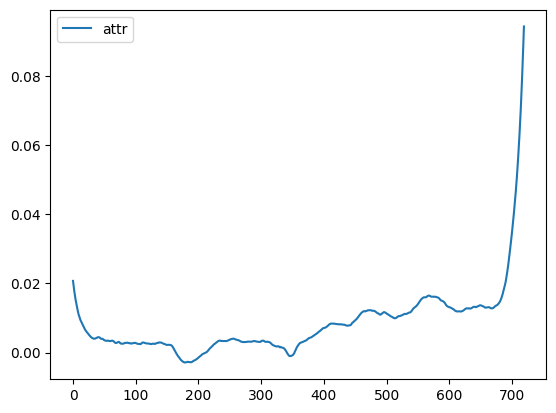

In [25]:
attr_df = pd.DataFrame({'attr':nt_ig_attr_score})
attr_df.plot()

<AxesSubplot: >

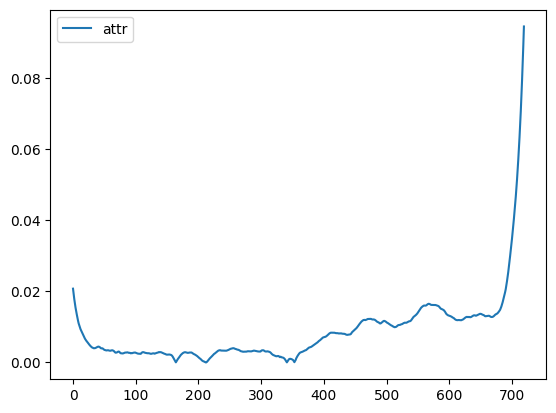

In [26]:
attr_df = attr_df.abs()
attr_df.plot()

## Outlier정의

In [27]:
IQR = 1.5*(attr_df.quantile(0.75)-attr_df.quantile(0.25))
outlier_max = attr_df.quantile(0.75)+IQR
outlier_min = attr_df.quantile(0.25)-IQR
candidate_attr = attr_df[(attr_df>=outlier_min) & (attr_df<=outlier_max)]
candidate_attr = candidate_attr.dropna()
candidate_attr

,attr
0,0.020742
1,0.019209
2,0.017827
3,0.016557
4,0.015425
...,...
690,0.020611
691,0.021642
692,0.022841
693,0.024066


<AxesSubplot: >

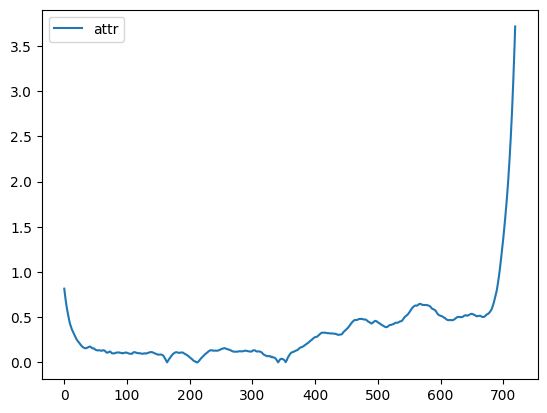

In [28]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
scaler.fit(candidate_attr.values)
m_attr_df = scaler.transform(attr_df.values)
m_attr_df = pd.DataFrame({"attr":m_attr_df.reshape(-1)})
# attr_df = attr_df.abs()
# attr_std = attr_df.std().item()
# attr_min = attr_df.min().item()
m_attr_df.plot()

In [29]:
m_attr_df.describe()

,attr
count,720.000000
mean,0.342432
std,0.413717
min,0.000000
25%,0.109839
50%,0.202341
75%,0.478619
max,3.716313


<AxesSubplot: >

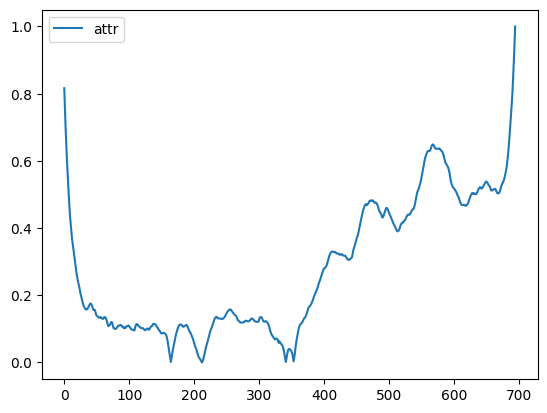

In [30]:
m_attr_df[(m_attr_df>=0) & (m_attr_df<=1)].dropna().plot()

<AxesSubplot: >

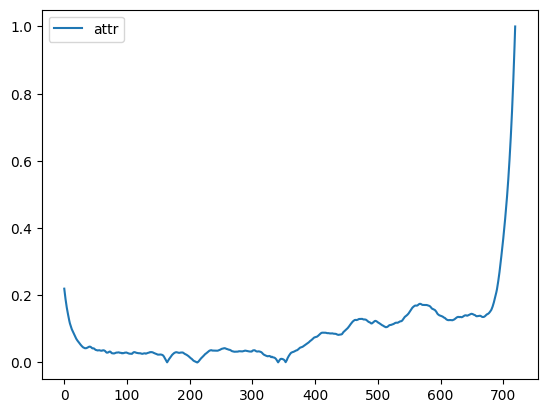

In [31]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
attr_df = scaler.fit_transform(attr_df.values)
attr_df = pd.DataFrame({"attr":attr_df.reshape(-1)})
# attr_df = attr_df.abs()
# attr_std = attr_df.std().item()
# attr_min = attr_df.min().item()
attr_df.plot()

#### train_index구하기

In [32]:
index_list = []

for hyper_para in np.arange(0.00,1.01,0.01):
    append_idx = list(m_attr_df[(m_attr_df['attr']>=hyper_para)].index)
    index_list.append(append_idx)
len(index_list) # train_index의 리스트

101

In [33]:
len_list=[]
for i in range(100):
    len_list.append(len(index_list[i]))


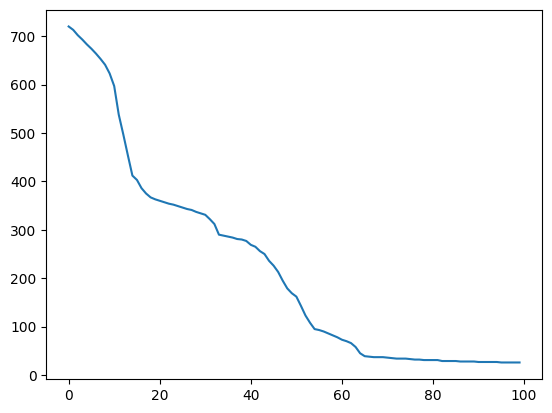

In [34]:
plt.plot(np.arange(100),len_list) # 포함되는 time_index의 갯수

In [35]:
for val_x,val_y in validation:
    print(val_x,val_y)

tensor([[ 0.0000, -0.6330, -0.6330,  ...,  4.9240,  5.1350,  4.6430],
        [-0.6330, -0.6330, -0.7030,  ...,  5.1350,  4.6430,  4.5020],
        [-0.6330, -0.7030, -1.2660,  ...,  4.6430,  4.5020,  4.5730],
        ...,
        [ 1.6880,  1.6180,  1.9700,  ...,  2.7440,  3.0250,  3.0250],
        [ 1.6180,  1.9700,  1.7590,  ...,  3.0250,  3.0250,  3.8690],
        [ 1.9700,  1.7590,  1.4770,  ...,  3.0250,  3.8690,  4.5020]],
       device='cuda:0') tensor([[ 4.5020,  4.5730,  4.6430,  ...,  9.2150,  9.0040,  8.7230],
        [ 4.5730,  4.6430,  4.5020,  ...,  9.0040,  8.7230,  8.8640],
        [ 4.6430,  4.5020,  4.1500,  ...,  8.7230,  8.8640,  8.7930],
        ...,
        [ 3.8690,  4.5020,  5.2060,  ..., 10.6220, 10.8330, 10.9040],
        [ 4.5020,  5.2060,  5.8390,  ..., 10.8330, 10.9040, 10.8330],
        [ 5.2060,  5.8390,  5.7680,  ..., 10.9040, 10.8330, 11.6780]],
       device='cuda:0')
tensor([[1.7590, 1.4770, 1.5480,  ..., 3.8690, 4.5020, 5.2060],
        [1.4770, 1.5

       device='cuda:0') tensor([[14.6320, 12.2400,  9.7080,  ..., 10.4110,  8.5120,  8.5120],
        [12.2400,  9.7080,  8.6530,  ...,  8.5120,  8.5120,  8.2310],
        [ 9.7080,  8.6530,  9.9890,  ...,  8.5120,  8.2310,  8.3010],
        ...,
        [ 7.6680,  7.4570,  7.0350,  ..., 10.6930, 10.9740, 12.2400],
        [ 7.4570,  7.0350,  7.1750,  ..., 10.9740, 12.2400, 12.6620],
        [ 7.0350,  7.1750,  7.0350,  ..., 12.2400, 12.6620, 13.4360]],
       device='cuda:0')
tensor([[11.6070, 10.4110,  9.8490,  ...,  7.6680,  7.4570,  7.0350],
        [10.4110,  9.8490,  9.3560,  ...,  7.4570,  7.0350,  7.1750],
        [ 9.8490,  9.3560,  8.9340,  ...,  7.0350,  7.1750,  7.0350],
        ...,
        [ 8.5120,  9.9890, 10.3410,  ...,  8.3010,  9.0040,  9.1450],
        [ 9.9890, 10.3410,  9.9190,  ...,  9.0040,  9.1450,  7.4570],
        [10.3410,  9.9190,  9.4260,  ...,  9.1450,  7.4570,  6.8240]],
       device='cuda:0') tensor([[ 7.1750,  7.0350,  6.8940,  ..., 12.6620, 13.4360, 

In [36]:
val_x

tensor([[11.5370, 11.5370, 11.8180,  ..., 12.3810, 11.6070, 10.7630],
        [11.5370, 11.8180, 11.5370,  ..., 11.6070, 10.7630, 10.0600],
        [11.8180, 11.5370, 11.6780,  ..., 10.7630, 10.0600,  9.6380]],
       device='cuda:0')

In [37]:
### 원래 난수가 선언된 위치
m = len(validation)
n = len(training)
cnt = 0
num_epochs = 100
mse_out_list = []
mae_out_list = []
smape_out_list = []
rmse_out_list = []
for idx in index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    train_idx = idx
    minimal_loss=np.inf
    model = Model(train_idx).to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    result = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs
            
            outputs = model(inputs)
            outputs = outputs.view(-1,1)
            labels = labels.view(-1,1)            
            # defining loss
            loss = MSE(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch == 99:    
            print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
        
        if (running_loss/n)*100<minimal_loss:
            best_model = copy.deepcopy(model)
            minimal_loss = (running_loss/n)*100
            print("changed")

    model = best_model
    cnt+=1
    # 모델 Fully-Training 완료
    
    pred = torch.FloatTensor().to(device)
    val_target = torch.FloatTensor().to(device)
    for val_x,val_y in validation:
        tmp_pred = model(val_x)
        pred = torch.concat([pred,tmp_pred], dim=0)
        val_target = torch.concat([val_target,val_y],dim = 0)
    pred = pred.view(-1,1)
    val_target = val_target.view(-1,1)
    result = MSE(pred,val_target).item()
    mse_out_list.append(result)
    mae_out_list.append(MAE()(pred,val_target).item())
    rmse_out_list.append(RMSE()(pred,val_target).item())
    smape_out_list.append(SMAPE()(pred,val_target).item()*100)

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
0번째 모델 Training 완료 마지막 Epoch loss:1269.0468894776386
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
1번째 모델 Training 완료 마지막 Epoch loss:1266.7556683621815
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
change

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
21번째 모델 Training 완료 마지막 Epoch loss:1228.5926370764498
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
22번째 모델 Training 완료 마지막 Epoch loss:1234.7137748296536
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
23번째 모델 Training 완료 마지막 Epoch loss:1234.7006850506193
changed
changed
changed
changed
changed
changed
changed
changed
change

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
50번째 모델 Training 완료 마지막 Epoch loss:1318.2184874711925
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
59번째 모델 Training 완료 마지막 Epoch loss:1360.3277704823556
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
69번째 모델 Training 완료 마지막 Epoch loss:1567.7729825877664
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
79번째 모델 Training 완료 마지막 Epoch loss:1585.0266532083253
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
88번째 모델 Training 완료 마지막 Epoch loss:1635.927695245599
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
98번째 모델 Training 완료 마지막 Epoch loss:1642.8817450700692
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

In [38]:
val_y # 다음 예측 타겟값

tensor([[10.0600,  9.6380,  9.7080,  ...,  5.6280,  4.6430,  5.2760],
        [ 9.6380,  9.7080,  9.8490,  ...,  4.6430,  5.2760,  6.6830],
        [ 9.7080,  9.8490, 10.2710,  ...,  5.2760,  6.6830,  6.7530]],
       device='cuda:0')

In [39]:
val_x # 예측 하는 값

tensor([[11.5370, 11.5370, 11.8180,  ..., 12.3810, 11.6070, 10.7630],
        [11.5370, 11.8180, 11.5370,  ..., 11.6070, 10.7630, 10.0600],
        [11.8180, 11.5370, 11.6780,  ..., 10.7630, 10.0600,  9.6380]],
       device='cuda:0')

In [40]:
result/68

0.19466963936300838

In [41]:
val_x.size()

torch.Size([3, 720])

          out
64  11.926383


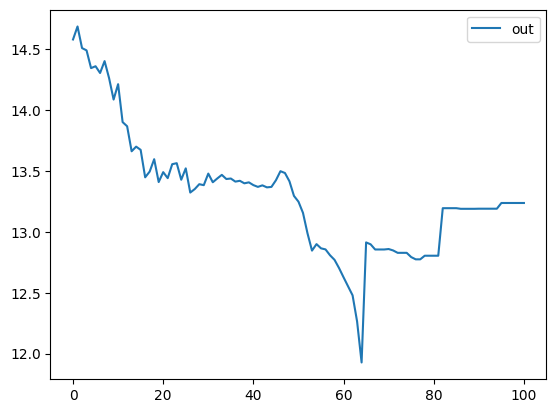

In [42]:
out_df = pd.DataFrame({"out":mse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [43]:
out_df

,out
0,14.581647
1,14.688575
2,14.510886
3,14.492229
4,14.346369
...,...
96,13.237535
97,13.237535
98,13.237535
99,13.237535


         out
64  2.796613


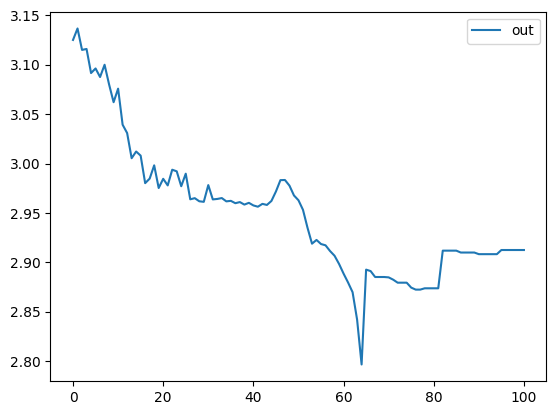

In [44]:
out_df = pd.DataFrame({"out":mae_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [45]:
out_df

,out
0,3.125252
1,3.136858
2,3.115153
3,3.116110
4,3.091716
...,...
96,2.912524
97,2.912524
98,2.912524
99,2.912524


          out
64  37.351185


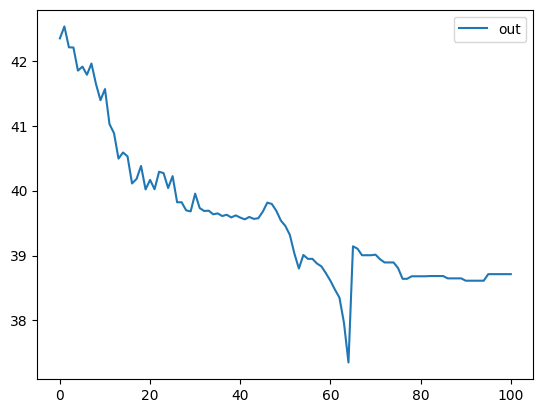

In [46]:
out_df = pd.DataFrame({"out":smape_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [47]:
out_df

,out
0,42.346749
1,42.530137
2,42.209136
3,42.206171
4,41.850060
...,...
96,38.712689
97,38.712689
98,38.712689
99,38.712689


        out
64  3.45346


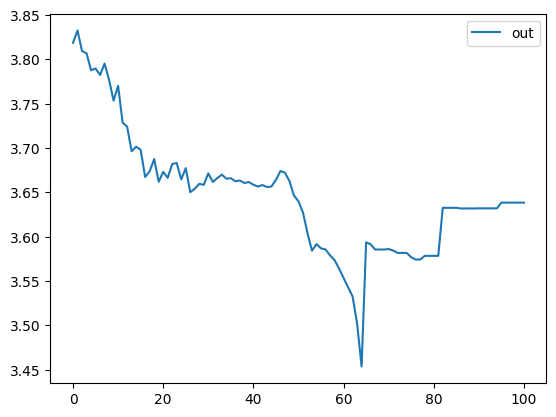

In [48]:
out_df = pd.DataFrame({"out":rmse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [49]:
out_df

,out
0,3.818592
1,3.832568
2,3.809316
3,3.806866
4,3.787660
...,...
96,3.638342
97,3.638342
98,3.638342
99,3.638342


In [50]:
attr_df.describe()

,attr
count,720.000000
mean,0.092143
std,0.111325
min,0.000000
25%,0.029556
50%,0.054447
75%,0.128789
max,1.000000
